# 13. ViT

## План

1. Архитектура Vision Transformer
2. SSL: DINOv2
3. Saliency Maps from Attention Maps
4. Few-Shot Learning (Linear Probing) для CLIP

## 1. Архитектура Vision Transformer

Трансформер родился в NLP, где типичная задача состоит в обработке упорядоченной последовательности *токенов*, представляющих слова или их части. Для зрения архитектура не сильно отличается от классического Encoder Transformer-a и состоит из:

1. Tokenizer - берёт картинку и возвращает набор токенов
2. Transformer Encoder Block - пре-нормализация, MHA, MLP и residual connections 
3. Positional embeddings - способ кодирования позиционной информации о порядке токенов (для MHSA)
4. Classification token [CLS] - спецтокен, фичи которого используются для классификации
5. Classification head - MLP, делающий предсказание по [CLS]

<div>
<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/vit_architecture.jpg" width=70%/>
</div>

### Tokenizer

У нас нет необходимости думать о кодировании дискретных символов, но зато нужно решить только проблему с преобразованием пространства картинки в последовательность.

Токенизатор должен принять изображение, нарезать его на непересекающиеся патчи, вытянуть их в векторы и спроецировать линейным преобразованием в новое пространство. Можно делать это по-разному:
- MaxPooling + Linear
- Conv2d

In [1]:
import torch
from torch import nn


class PatchEmbed(nn.Module):
    """
    Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        assert img_size % patch_size == 0, f"{img_size} should be devided by {patch_size}"
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        # YOUR CODE
        self.proj = nn.Conv2d(in_channels=in_chans, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # B x num_patches x embed_dim
        # YOUR CODE
        return self.proj(x).flatten(2).transpose(2, 1)  # B x embed_dim x 14 x 14

In [4]:
(80 / 4) ** 2

400.0

In [2]:
tokenizer = PatchEmbed(img_size=80, patch_size=4, in_chans=3, embed_dim=15)
dummy_batch = torch.zeros((5, 3, 80, 80))
tokenizer_result = tokenizer(dummy_batch)
tokenizer_result.shape

torch.Size([5, 400, 15])

### Multi-Head Attention (MHA)
<img src="https://data-science-blog.com/wp-content/uploads/2022/01/mha_img_original.png" style="width:75%">

In [5]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0.0, proj_drop=0.0):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim**-0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        # YOUR CODE
        # x: B x N x dimя
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        # qkv: 3 × B × num_heads × d × head_dim
        q, k, v = qkv[0], qkv[1], qkv[2]
        # v: B × num_heads × n × head_dim
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        # attn: B × num_heads × n × n
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        # B × num_heads × n × head_dim
        x = self.proj(x)
        # B × n × (num_heads × head_dim)
        x = self.proj_drop(x)
        return x, attn

In [6]:
x_in = torch.randn(11, 25, 40)

x, attn = Attention(40, 8)(x_in)
x.shape, attn.shape

(torch.Size([11, 25, 40]), torch.Size([11, 8, 25, 25]))

### Stochastic depth

Стохастическая глубина была представлена в [статье](https://arxiv.org/pdf/1603.09382.pdf) как способ уменьшения переобучения. Вы можете думать об этом как о Dropout, применённом к остаточным ветвям. ResNet-блок со стохастической глубиной выглядит как `y = x + DropPath(ResidualNet(x))` вместо классического `y = x + ResidualNet(x)`.

Реализуем модуль DropPath. Его единственный параметр — `drop_prob`, вероятность обнуления входа. Не забудьте делить результат на `(1-drop_prob)`, чтобы сохранить среднее значение выхода в режиме обучения (как это делалось в первом домашнем задании при реализации Dropout).

In [7]:
def drop_path(x, drop_prob: float = 0.0, training: bool = False):
    if drop_prob == 0.0 or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks)."""

    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

### Transformer Encoder Block
<img src="https://theaisummer.com/static/aa65d942973255da238052d8cdfa4fcd/7d4ec/the-transformer-block-vit.png" style="width:25%">

Собираем блок из нормализаций, MHA, Feed-Forward-а и skip connections


In [8]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.0):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [9]:
class Block(nn.Module):
    def __init__(
        self,
        dim,
        num_heads,
        mlp_ratio=4.0,
        qkv_bias=False,
        qk_scale=None,
        drop=0.0,
        attn_drop=0.0,
        drop_path=0.0,
        act_layer=nn.GELU,
        norm_layer=nn.LayerNorm,
    ):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop
        )
        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, return_attention=False):
        # YOUR CODE
        y, attn = self.attn(self.norm1(x))
        if return_attention:
            return attn
        x = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

### Positional Encoding
До сих пор информация о позиции токена на картинке не учитывалась. В ViT принято использовать обучаемые позиционные эмбеддинги.

### [CLS]-токен

Ванильный Vision Transformer использует довольно необычный способ получения эмбеддинга всего изображения для окончательного предсказания. Он добавляет еще один токен, названный class-token, со своим собственным позиционным эмбеддингом, и берет его фичи в качестве окончательного эмбеддинга изображения. Альтернативный подход, заимствованный из CNN, заключается в использовании глобального mean pooling-а, что ещё и чуть экономнее по памяти. Будучи более простым в реализации, пулинг приводит к более простой интерпретации взаимодействия патчей (в ванильном ViT все межпатчевые связи могут быть выучены только через блоки внимания).

Однако в современных работах вы можете встретить оба подхода с равной вероятностью.

In [10]:
import math
import torch.nn.functional as F


class VisionTransformer(nn.Module):
    """Vision Transformer."""

    def __init__(
        self,
        img_size=[224],
        patch_size=16,
        in_chans=3,
        num_classes=0,
        embed_dim=768,
        depth=12,
        num_heads=12,
        mlp_ratio=4.0,
        qkv_bias=False,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.0,
        norm_layer=nn.LayerNorm,
        **kwargs,
    ):
        super().__init__()
        self.num_features = self.embed_dim = embed_dim

        self.patch_embed = PatchEmbed(
            img_size=img_size[0], patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim
        )
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList(
            [
                Block(
                    dim=embed_dim,
                    num_heads=num_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    qk_scale=qk_scale,
                    drop=drop_rate,
                    attn_drop=attn_drop_rate,
                    drop_path=dpr[i],
                    norm_layer=norm_layer,
                )
                for i in range(depth)
            ]
        )
        self.norm = norm_layer(embed_dim)

        # Classifier head
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def interpolate_pos_encoding(self, x, w, h):
        npatch = x.shape[1] - 1
        N = self.pos_embed.shape[1] - 1
        if npatch == N and w == h:
            return self.pos_embed
        class_pos_embed = self.pos_embed[:, 0]
        patch_pos_embed = self.pos_embed[:, 1:]
        dim = x.shape[-1]
        w0 = w // self.patch_embed.patch_size
        h0 = h // self.patch_embed.patch_size
        # we add a small number to avoid floating point error in the interpolation
        # see discussion at https://github.com/facebookresearch/dino/issues/8
        w0, h0 = w0 + 0.1, h0 + 0.1
        patch_pos_embed = F.interpolate(
            patch_pos_embed.reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim).permute(0, 3, 1, 2),
            scale_factor=(w0 / math.sqrt(N), h0 / math.sqrt(N)),
            mode="bicubic",
        )
        assert int(w0) == patch_pos_embed.shape[-2] and int(h0) == patch_pos_embed.shape[-1]
        patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
        return torch.cat((class_pos_embed.unsqueeze(0), patch_pos_embed), dim=1)

    def prepare_tokens(self, x):
        B, nc, w, h = x.shape
        x = self.patch_embed(x)  # patch linear embedding

        # add the [CLS] token to the embed patch tokens
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # add positional encoding to each token
        x = x + self.interpolate_pos_encoding(x, w, h)

        return self.pos_drop(x)

    def forward(self, x):
        x = self.prepare_tokens(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        return x[:, 0]  # [CLS]

    def get_last_selfattention(self, x):
        x = self.prepare_tokens(x)
        for i, blk in enumerate(self.blocks):
            if i < len(self.blocks) - 1:
                x = blk(x)
            else:
                # return attention of the last block
                return blk(x, return_attention=True)

    def get_intermediate_layers(self, x, n=1):
        x = self.prepare_tokens(x)
        # we return the output tokens from the `n` last blocks
        output = []
        for i, blk in enumerate(self.blocks):
            x = blk(x)
            if len(self.blocks) - i <= n:
                output.append(self.norm(x))
        return output

In [11]:
model_config = {
    "img_size": [64],
    "patch_size": 8,
    "embed_dim": 192,
    "mlp_ratio": 2,
    "depth": 9,
    "qkv_bias": True,
}


model = VisionTransformer(**model_config)

## 2. SSL (DINO)

### Self-Supervision through Knowledge Distillation
<div class="row">
    <img src="./resources/simclr.png" width=40%/>
    <img src="./resources/dino.png" width=40%/>
</div>

In [14]:
from torchvision import transforms as T
import utils

img_mean, img_std = (0.4802, 0.4481, 0.3975), (0.2770, 0.2691, 0.2821)


class DataAugmentationDINO(object):
    def __init__(self, global_crops_scale, local_crops_scale, local_crops_number):
        flip_and_color_jitter = T.Compose(
            [
                T.RandomHorizontalFlip(p=0.5),
                T.RandomApply([T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)], p=0.8),
                T.RandomGrayscale(p=0.2),
            ]
        )
        normalize = T.Compose(
            [
                T.ToTensor(),
                T.Normalize(img_mean, img_std),
            ]
        )

        # first global crop
        self.global_transfo1 = T.Compose(
            [
                T.RandomResizedCrop(224, scale=global_crops_scale, interpolation=T.InterpolationMode("bicubic")),
                flip_and_color_jitter,
                utils.GaussianBlur(1.0),
                normalize,
            ]
        )
        # second global crop
        self.global_transfo2 = T.Compose(
            [
                T.RandomResizedCrop(224, scale=global_crops_scale, interpolation=T.InterpolationMode("bicubic")),
                flip_and_color_jitter,
                utils.GaussianBlur(0.1),
                utils.Solarization(0.2),
                normalize,
            ]
        )
        # transformation for the local small crops
        self.local_crops_number = local_crops_number
        self.local_transfo = T.Compose(
            [
                T.RandomResizedCrop(96, scale=local_crops_scale, interpolation=T.InterpolationMode("bicubic")),
                flip_and_color_jitter,
                utils.GaussianBlur(0.5),
                normalize,
            ]
        )

    def __call__(self, image):
        crops = []
        crops.append(self.global_transfo1(image))
        crops.append(self.global_transfo2(image))
        for _ in range(self.local_crops_number):
            crops.append(self.local_transfo(image))
        return crops

In [13]:
import torch.nn.functional as F


class DINOLoss(nn.Module):
    def __init__(
        self,
        out_dim,
        ncrops,
        warmup_teacher_temp,
        teacher_temp,
        warmup_teacher_temp_epochs,
        nepochs,
        student_temp=0.1,
        center_momentum=0.9,
    ):
        super().__init__()
        self.student_temp = student_temp
        self.center_momentum = center_momentum
        self.ncrops = ncrops
        self.register_buffer("center", torch.zeros(1, out_dim))
        # we apply a warm up for the teacher temperature because
        # a too high temperature makes the training instable at the beginning
        self.teacher_temp_schedule = np.concatenate(
            (
                np.linspace(warmup_teacher_temp, teacher_temp, warmup_teacher_temp_epochs),
                np.ones(nepochs - warmup_teacher_temp_epochs) * teacher_temp,
            )
        )

    def forward(self, student_output, teacher_output, epoch):
        """
        Cross-entropy between softmax outputs of the teacher and student networks.
        """
        student_out = student_output / self.student_temp
        student_out = student_out.chunk(self.ncrops)

        # teacher centering and sharpening
        temp = self.teacher_temp_schedule[epoch]
        teacher_out = F.softmax((teacher_output - self.center) / temp, dim=-1)
        teacher_out = teacher_out.detach().chunk(2)

        total_loss = 0
        n_loss_terms = 0
        for iq, q in enumerate(teacher_out):
            for v in range(len(student_out)):
                if v == iq:
                    # we skip cases where student and teacher operate on the same view
                    continue
                loss = torch.sum(-q * F.log_softmax(student_out[v], dim=-1), dim=-1)
                total_loss += loss.mean()
                n_loss_terms += 1
        total_loss /= n_loss_terms
        self.update_center(teacher_output)
        return total_loss

    @torch.no_grad()
    def update_center(self, teacher_output):
        """
        Update center used for teacher output.
        """
        batch_center = torch.sum(teacher_output, dim=0, keepdim=True)
        batch_center = batch_center / (len(teacher_output))

        # EMA update
        self.center = self.center * self.center_momentum + batch_center * (1 - self.center_momentum)

In [ ]:
def train_one_epoch(
    student,
    teacher,
    dino_loss,
    data_loader,
    optimizer,
    lr_schedule,
    wd_schedule,
    momentum_schedule,
    epoch,
    fp16_scaler,
    args,
):
    for it, (images, _) in enumerate(data_loader):
        # update weight decay and learning rate according to their schedule
        it = len(data_loader) * epoch + it  # global training iteration
        for i, param_group in enumerate(optimizer.param_groups):
            param_group["lr"] = lr_schedule[it]
            if i == 0:  # only the first group is regularized
                param_group["weight_decay"] = wd_schedule[it]

        # move images to gpu
        images = [im.cuda(non_blocking=True) for im in images]
        # teacher and student forward passes + compute dino loss
        with torch.cuda.amp.autocast(fp16_scaler is not None):
            teacher_output = teacher(images[:2])  # only the 2 global views pass through the teacher
            student_output = student(images)
            loss = dino_loss(student_output, teacher_output, epoch)

        if not math.isfinite(loss.item()):
            print("Loss is {}, stopping training".format(loss.item()), force=True)
            break

        # student update
        optimizer.zero_grad()
        param_norms = None
        if fp16_scaler is None:
            loss.backward()
            if args.clip_grad:
                param_norms = utils.clip_gradients(student, args.clip_grad)
            utils.cancel_gradients_last_layer(epoch, student, args.freeze_last_layer)
            optimizer.step()
        else:
            fp16_scaler.scale(loss).backward()
            if args.clip_grad:
                fp16_scaler.unscale_(optimizer)  # unscale the gradients of optimizer's assigned params in-place
                param_norms = utils.clip_gradients(student, args.clip_grad)
            utils.cancel_gradients_last_layer(epoch, student, args.freeze_last_layer)
            fp16_scaler.step(optimizer)
            fp16_scaler.update()

        # EMA update for the teacher
        with torch.no_grad():
            m = momentum_schedule[it]  # momentum parameter
            for param_q, param_k in zip(student.module.parameters(), teacher.parameters()):
                param_k.data.mul_(m).add_((1 - m) * param_q.detach().data)

##  3. Saliency Maps from Attention Maps

In [13]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
from PIL import Image
import requests

processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
model = AutoModelForImageClassification.from_pretrained('facebook/dinov2-base')


Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
processor.crop_size = {'height': 224, 'width': 224}

In [15]:
image = Image.open("resources/img1.jpg").convert("RGB").resize((224, 224))

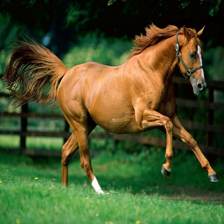

In [16]:
image

In [17]:
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs, output_attentions=True)

Dinov2Model is using Dinov2SdpaSelfAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [18]:
model.forward?

Signature:
model.forward(
    pixel_values: Optional[torch.Tensor] = None,
    head_mask: Optional[torch.Tensor] = None,
    labels: Optional[torch.Tensor] = None,
    output_attentions: Optional[bool] = None,
    output_hidden_states: Optional[bool] = None,
    return_dict: Optional[bool] = None,
) -> Union[tuple, transformers.modeling_outputs.ImageClassifierOutput]
Docstring:
The [`Dinov2ForImageClassification`] forward method, overrides the `__call__` special method.

<Tip>

Although the recipe for forward pass needs to be defined within this function, one should call the [`Module`]
instance afterwards instead of this since the former takes care of running the pre and post processing steps while
the latter silently ignores them.

</Tip>

Args:
    pixel_values (`torch.FloatTensor` of shape `(batch_size, num_channels, height, width)`):
        Pixel values. Pixel values can be obtained using [`AutoImageProcessor`]. See
        [`BitImageProcessor.preprocess`] for details.

    head_m

In [19]:
inputs['pixel_values'].shape

torch.Size([1, 3, 224, 224])

In [22]:
# Function to visualize attention
def visualize_attention(image, attention_map, patch_size=16):
    # Upsample the attention map to match the original image size
    upsampled_attention = torch.nn.functional.interpolate(
        attention_map.unsqueeze(0).unsqueeze(0),  # [1, 1, N, N]
        scale_factor=patch_size,
        mode='bilinear',
        align_corners=False
    ).squeeze()
    
    # Normalize for better visualization
    upsampled_attention = (upsampled_attention - upsampled_attention.min()) / (
        upsampled_attention.max() - upsampled_attention.min()
    )
    # Overlay attention on the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.imshow(upsampled_attention.detach().numpy(), cmap='jet', alpha=0.5)  # Use alpha for blending
    plt.colorbar()
    plt.axis('off')
    plt.show()

In [24]:
import matplotlib.pyplot as plt

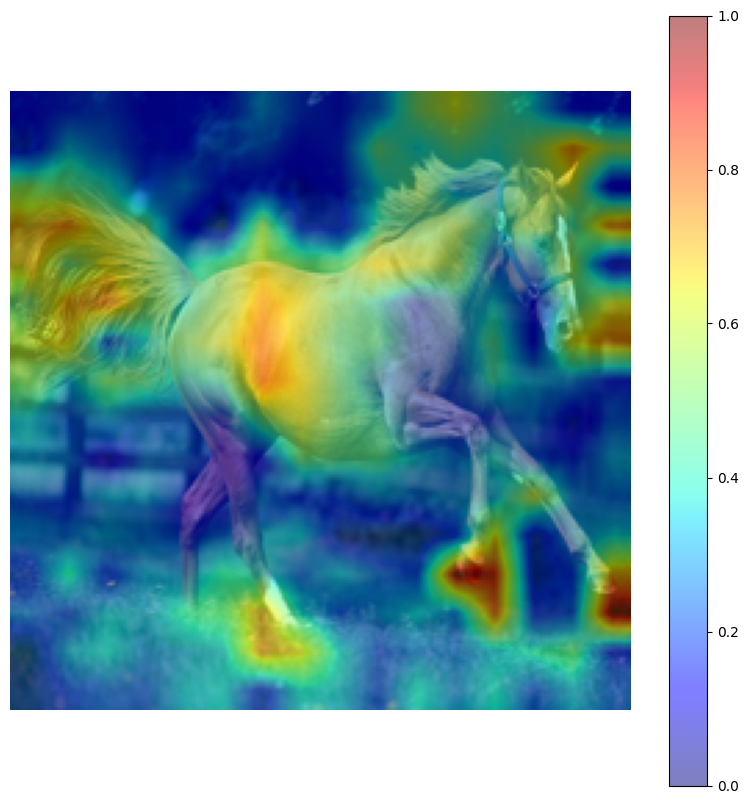

In [25]:
last_layer_attention = outputs.attentions[-1]  # Shape: [batch_size, num_heads, num_tokens, num_tokens]
cls_attention = last_layer_attention[0].mean(dim=0)  # усредняем по головам

# CLS -> патчи
cls_to_patches_attention = cls_attention[1:, 0]  # не учитываем аттеншен CLS к CLS
patch_grid_size = int(cls_to_patches_attention.shape[0] ** 0.5)
cls_to_patches_attention = cls_to_patches_attention.view(patch_grid_size, patch_grid_size)

# Visualize the attention map
visualize_attention(image, cls_to_patches_attention, patch_size=14)

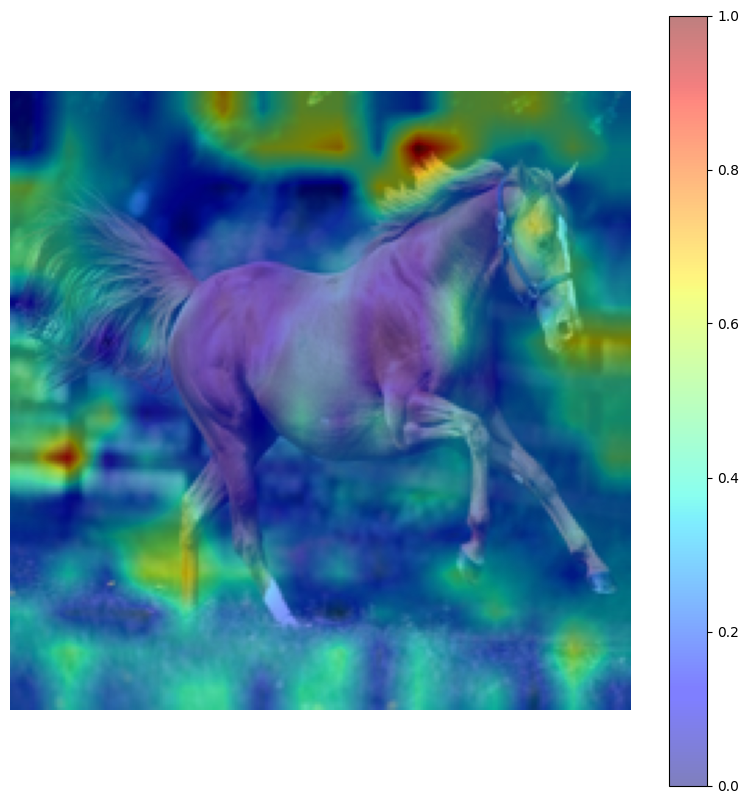

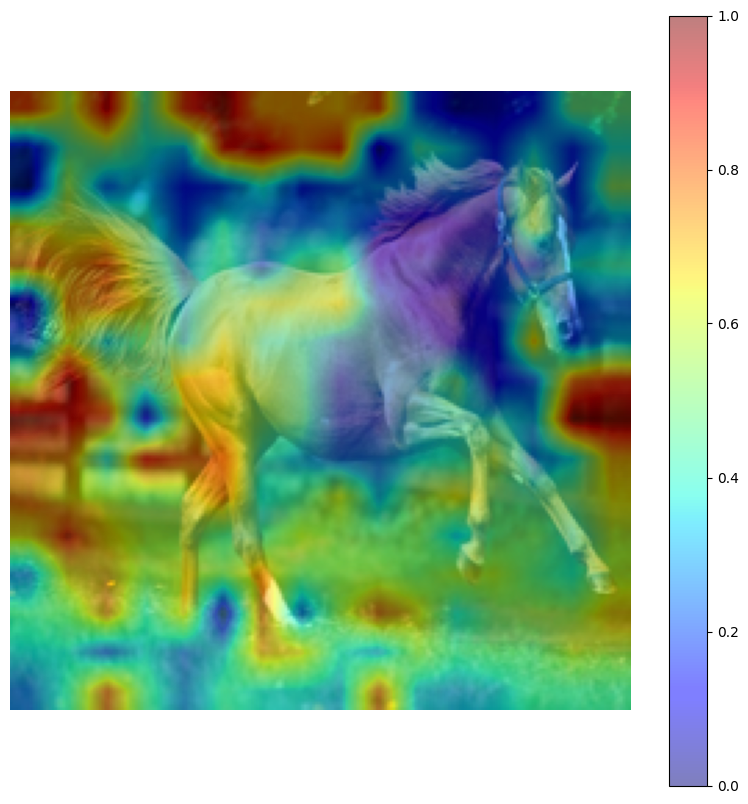

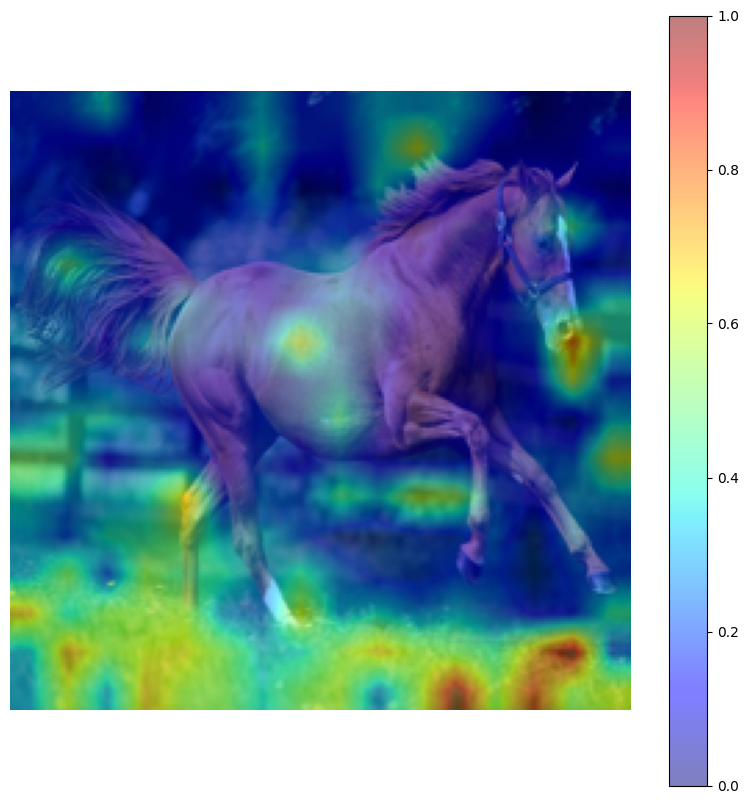

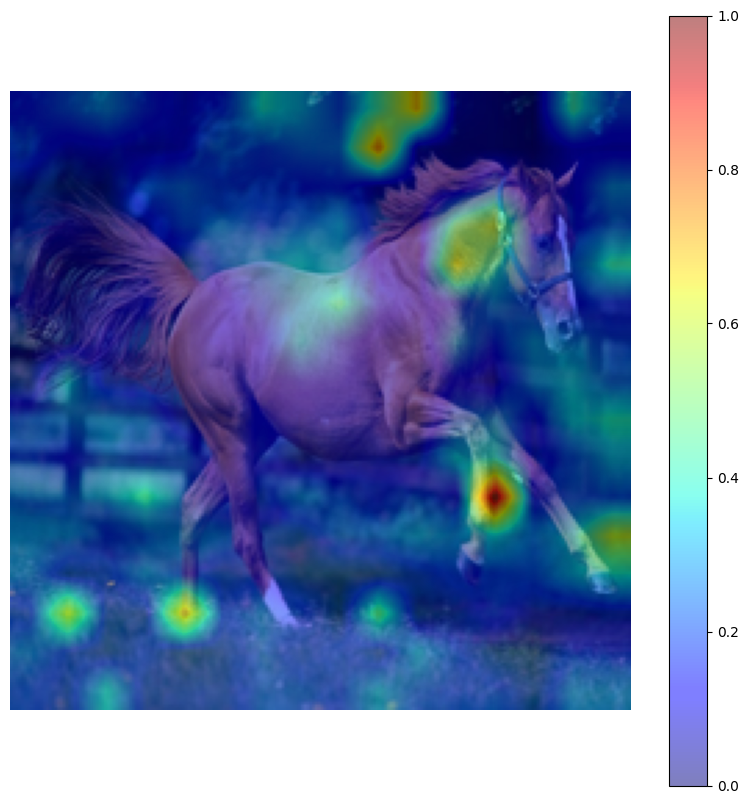

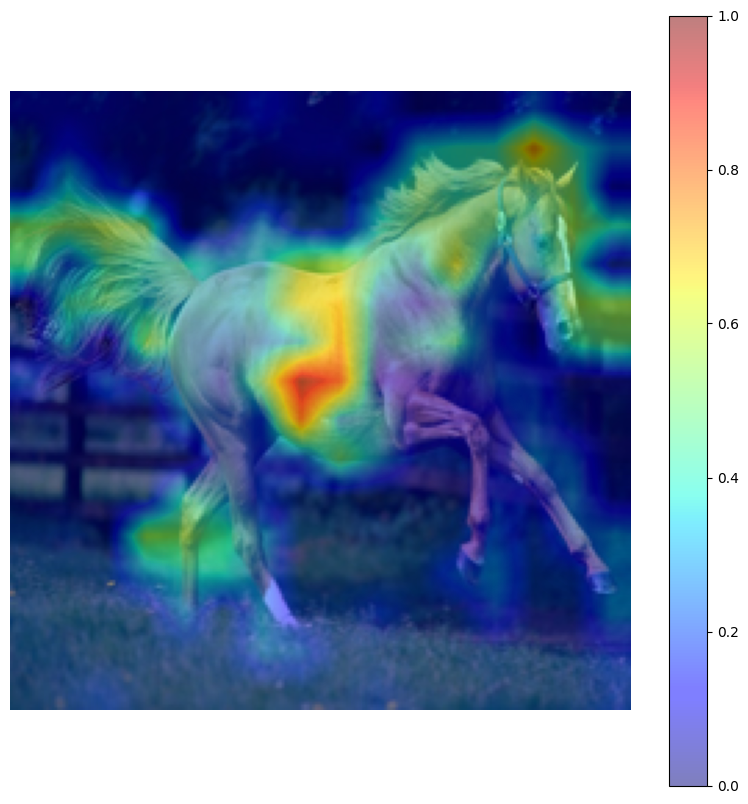

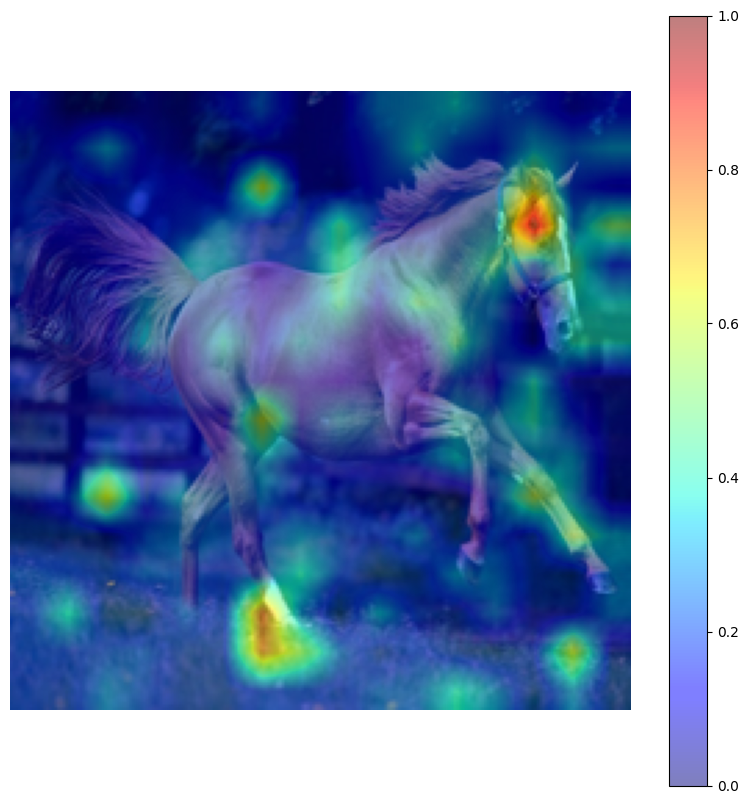

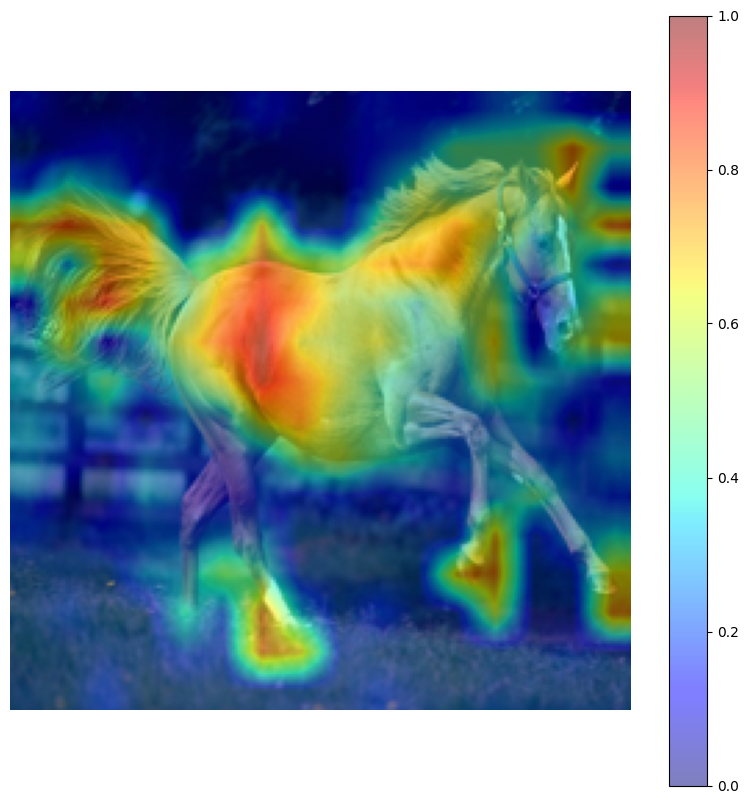

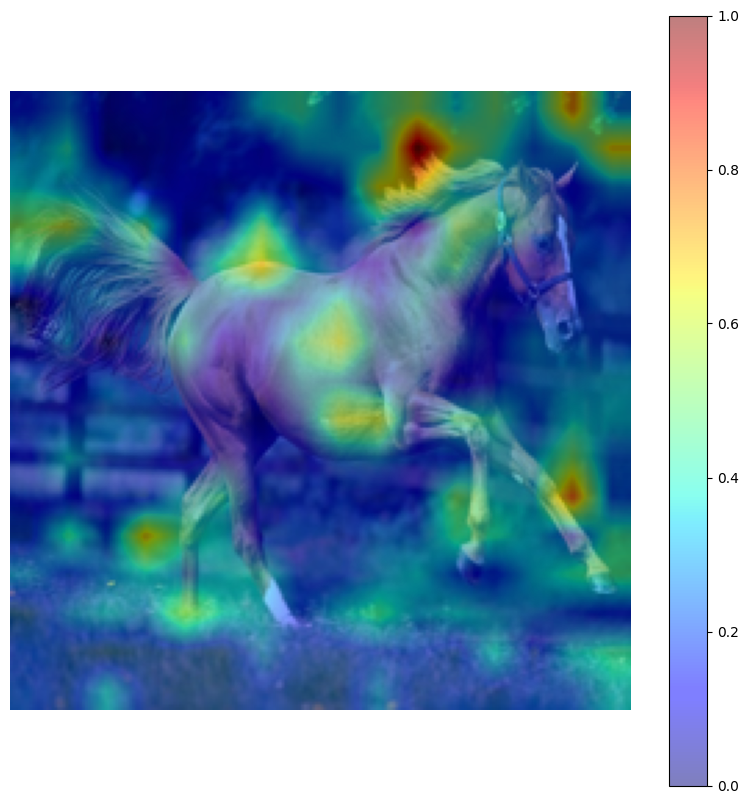

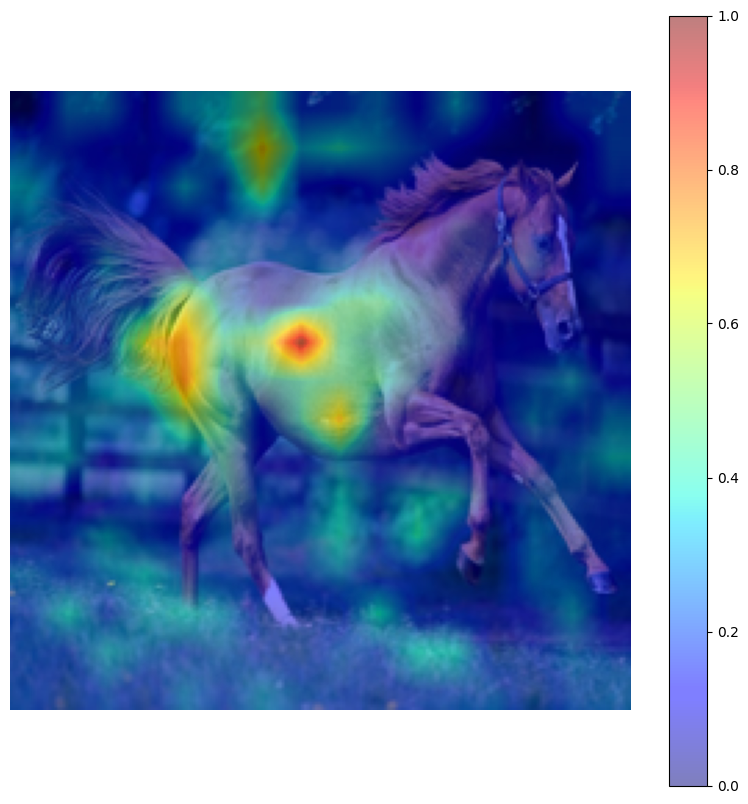

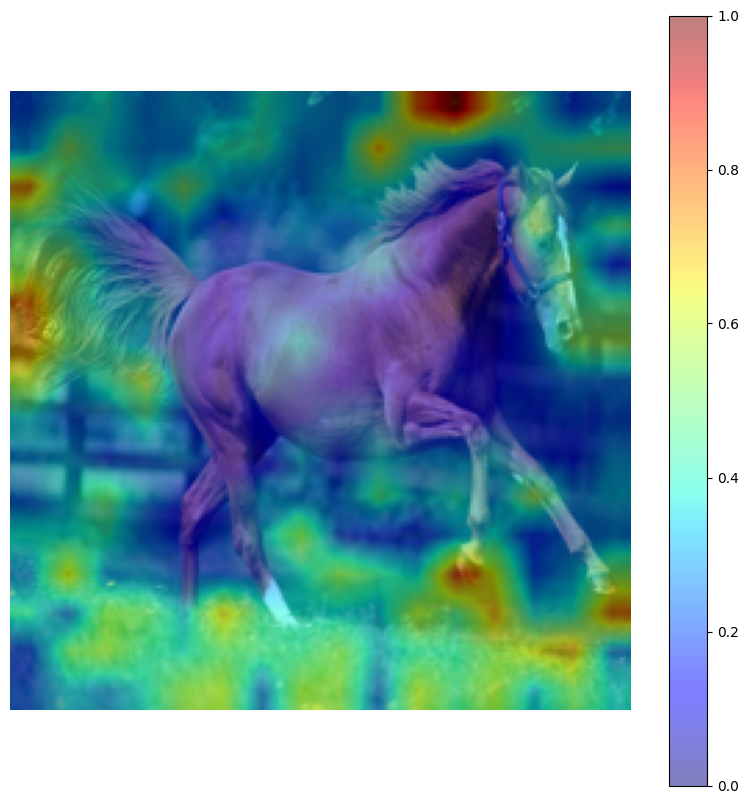

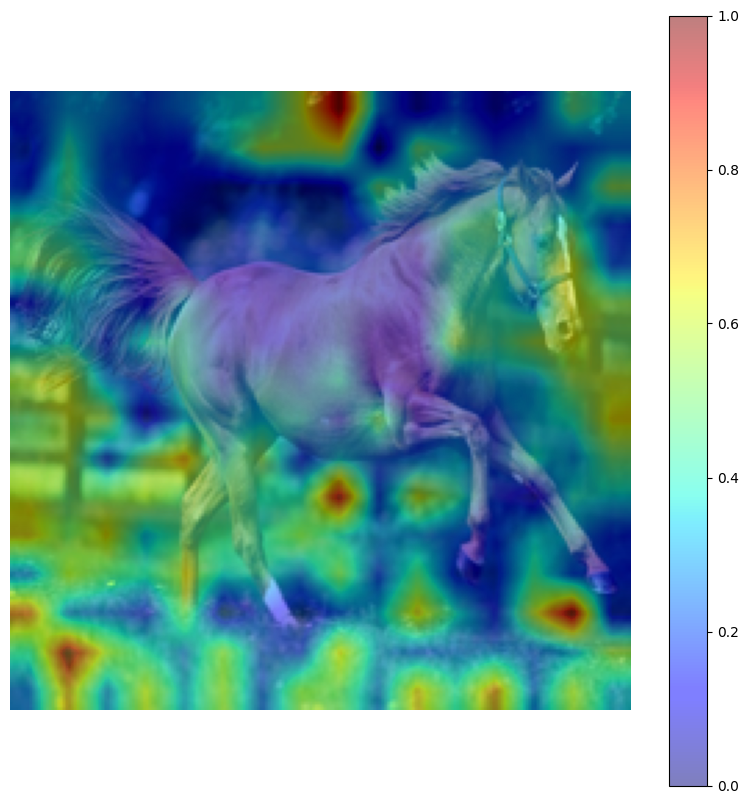

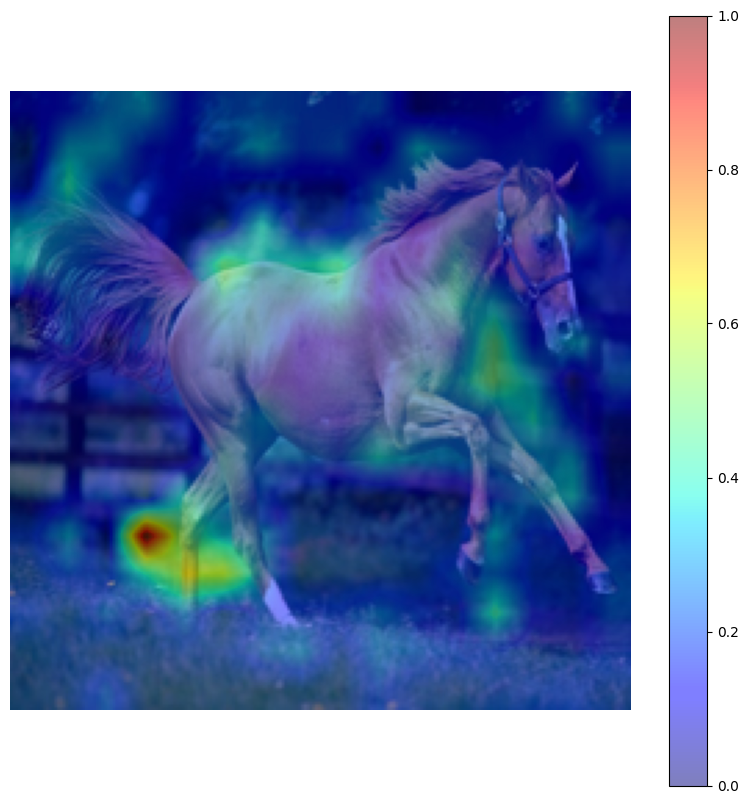

In [30]:
for head_idx in range(last_layer_attention.shape[1]):
    last_layer_attention = outputs.attentions[-1]  # Shape: [batch_size, num_heads, num_tokens, num_tokens]
    cls_attention = last_layer_attention[0, head_idx]  # усредняем по головам
    
    # CLS -> патчи
    cls_to_patches_attention = cls_attention[1:, 0]  # не учитываем аттеншен CLS к CLS
    patch_grid_size = int(cls_to_patches_attention.shape[0] ** 0.5)
    cls_to_patches_attention = cls_to_patches_attention.view(patch_grid_size, patch_grid_size)
    
    # Visualize the attention map
    visualize_attention(image, cls_to_patches_attention, patch_size=14)

## 4. Few-Shot Learning (Linear Probing) для CLIP

<img src="https://images.ctfassets.net/kftzwdyauwt9/d9d46e4b-6d6a-4f9e-59a242ea1441/c7b386880f1af005fd02f159de7f4d00/overview-b.svg"
    height="500">

    
Оригинальная статья: [Learning Transferable Visual Models From Natural Language Supervision](https://arxiv.org/abs/2103.00020)

Предобученный CLIP берём из `transformers` от проекта **Hugging Face**

In [31]:
from torchvision.datasets import CIFAR100

In [ ]:
pip install transformers -q

In [32]:
test_data = CIFAR100(
    root = './data',
    train = False,
    download=True
)

Files already downloaded and verified


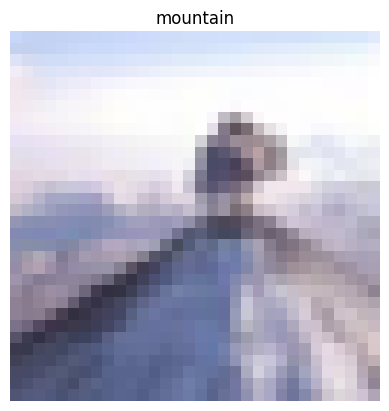

In [33]:
import matplotlib.pyplot as plt

# Выберем случайную картинку:

img = test_data[0][0]
label = test_data[0][1]

plt.imshow(img)
plt.title(test_data.classes[label])
plt.axis('off')
pass

Скачаем веса необходимых модулей CLIP-a

In [34]:
from transformers import CLIPProcessor, CLIPModel

clip_model = CLIPModel.from_pretrained('openai/clip-vit-base-patch16')
processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch16')

Используем названия классов в качестве текстовых промптов

In [36]:
test_data.classes

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle',
 'bowl',
 'boy',
 'bridge',
 'bus',
 'butterfly',
 'camel',
 'can',
 'castle',
 'caterpillar',
 'cattle',
 'chair',
 'chimpanzee',
 'clock',
 'cloud',
 'cockroach',
 'couch',
 'crab',
 'crocodile',
 'cup',
 'dinosaur',
 'dolphin',
 'elephant',
 'flatfish',
 'forest',
 'fox',
 'girl',
 'hamster',
 'house',
 'kangaroo',
 'keyboard',
 'lamp',
 'lawn_mower',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'man',
 'maple_tree',
 'motorcycle',
 'mountain',
 'mouse',
 'mushroom',
 'oak_tree',
 'orange',
 'orchid',
 'otter',
 'palm_tree',
 'pear',
 'pickup_truck',
 'pine_tree',
 'plain',
 'plate',
 'poppy',
 'porcupine',
 'possum',
 'rabbit',
 'raccoon',
 'ray',
 'road',
 'rocket',
 'rose',
 'sea',
 'seal',
 'shark',
 'shrew',
 'skunk',
 'skyscraper',
 'snail',
 'snake',
 'spider',
 'squirrel',
 'streetcar',
 'sunflower',
 'sweet_pepper',
 'table',
 'tank',
 'telephone',
 'television',
 'tig

In [35]:
import torch

inputs = processor(text=test_data.classes, images=img, return_tensors="pt", padding=True)

with torch.no_grad():
    outputs = clip_model(**inputs)
    logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

    pred_id = torch.argmax(probs, dim=1)

In [37]:
top3 = zip(probs.argsort(descending=True).squeeze().tolist()[:3], probs.sort(descending=True).values.squeeze().tolist()[:3])

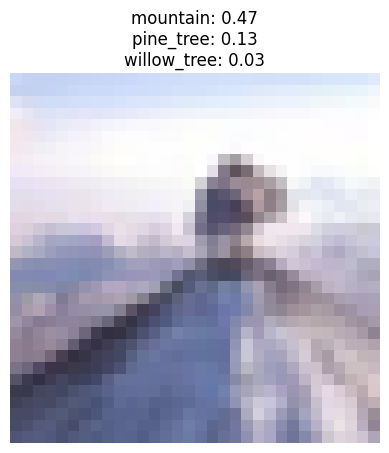

In [38]:
# Визуализируем предсказание:

img = test_data[0][0]

plt.imshow(img)
plt.title('\n'.join(f'{test_data.classes[idx]}: {p:.2f}' for idx, p in top3))
plt.axis('off')
pass

Теперь давайте оценим zero-shot accuracy

Предпосчитаем текстовые эмбеддинги, чтобы этого не приходилось делать для каждого батча

In [39]:
import torch

DEVICE=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda', index=0)

In [40]:
import gc

gc.collect(), torch.cuda.empty_cache()

(33833, None)

На гитхабе доступны [промпты](https://github.com/openai/CLIP/blob/main/data/prompts.md#cifar100) для CIFAR из оригинальной статьи.

In [41]:
templates = [
    'a photo of a {}.',
    'a blurry photo of a {}.',
    'a black and white photo of a {}.',
    'a low contrast photo of a {}.',
    'a high contrast photo of a {}.',
    'a bad photo of a {}.',
    'a good photo of a {}.',
    'a photo of a small {}.',
    'a photo of a big {}.',
    'a photo of the {}.',
    'a blurry photo of the {}.',
    'a black and white photo of the {}.',
    'a low contrast photo of the {}.',
    'a high contrast photo of the {}.',
    'a bad photo of the {}.',
    'a good photo of the {}.',
    'a photo of the small {}.',
    'a photo of the big {}.',
]

In [42]:
with torch.no_grad():
    # Возьмем текстовые части CLIP-а

    # Энкодер
    text_model = clip_model.text_model.to(DEVICE)

    # Проекция
    text_projection = clip_model.text_projection.to(DEVICE)

    # Посчитаем эмбеддинги
    # Для каждого класса
    class_embeds = []

    for class_name in test_data.classes:

        # Для каждого промпта

        class_sequences = processor(text=[p.format(class_name) for p in templates], return_tensors="pt", padding=True)
        class_sequences.to(DEVICE)

        # Инференс

        text_outputs = text_model.to(DEVICE)(**class_sequences)[1]
        class_sequences = class_sequences.to('cpu')

        text_embeds = text_projection.to(DEVICE)(text_outputs)

        text_outputs = text_outputs.to('cpu')

        # Нормировка
        text_embeds = (text_embeds / text_embeds.norm(dim=-1, keepdim=True)).cpu()
        # Усреднение по промптам и перенормировка
        text_embed = text_embeds.mean(0, keepdim=True)
        text_embed /= text_embed.norm()

        class_embeds.append(text_embed)

class_embeds = torch.cat(class_embeds)

In [43]:
class_embeds.shape

torch.Size([100, 512])

In [16]:
text_embeds.shape

torch.Size([18, 512])

In [44]:
# Очистка неиспользуемой памяти
import gc

del text_model
del text_projection

gc.collect(), torch.cuda.empty_cache()

(0, None)

Получили нормированные эбеддинги для каждого из 100 классов:

In [45]:
class_embeds.shape, class_embeds.norm(p=2,dim=1)

(torch.Size([100, 512]),
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000]))

In [46]:
import numpy as np

# Делаем батчи

batch_size = 10
num_batches = test_data.data.shape[0] // batch_size

batches = np.split(test_data.data, num_batches ,axis=0)
assert sum(b.shape[0] for b in batches) == test_data.data.shape[0]

Аналогично тексту, на каждой итерации будем делать то же самое с картинками:

In [47]:
from tqdm.notebook import tqdm

test_image_features = []
predicted_labels = []

# Энкодер
image_model = clip_model.vision_model.to(DEVICE)

# Проекция
image_projection = clip_model.visual_projection.to(DEVICE)

with torch.no_grad():
    for batch in tqdm(batches):

        image_sequences = processor(images=batch, return_tensors="pt", padding=True).to(DEVICE)

        # Инференс
        image_outputs = image_model(**image_sequences)[1]
        image_sequences = image_sequences.to('cpu')

        image_embeds = image_projection.cuda()(image_outputs)
        image_projection.cpu()
        image_outputs = image_outputs.to('cpu')

        test_image_features.append(image_outputs.numpy())

        # Нормировка
        image_embeds = (image_embeds / image_embeds.norm(dim=-1, keepdim=True)).cpu()

        # Подсчет similarity

        logit_scale = clip_model.logit_scale.exp()
        logits_per_text = torch.matmul(class_embeds.to(DEVICE), image_embeds.t().to(DEVICE)) * logit_scale.to(DEVICE).cpu()
        logits_per_image = logits_per_text.t()

        probs = logits_per_image.softmax(dim=1)

        predicted_labels += torch.argmax(probs, dim=1).reshape(-1).tolist()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [19]:
test_image_features = np.concatenate(test_image_features)
test_image_features.shape

(10000, 768)

In [22]:
DATA_PATH = "./data"

In [23]:
np.save(f'{DATA_PATH}/clip_test_feats.npy', test_image_features)

In [24]:
# np.save(f'{DATA_PATH}/clip_test_feats.npy', test_image_features)
test_image_features = np.load(f'{DATA_PATH}/clip_test_feats.npy')

In [25]:
pip install torchmetrics -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [26]:
from torchmetrics.classification import MulticlassAccuracy

true_labels = test_data.targets

acc = MulticlassAccuracy(
    num_classes=len(test_data.classes),
    average='weighted'
)(torch.tensor(predicted_labels), torch.tensor(true_labels)).item()

acc

0.6694999933242798

## **Дообучение (linear probing)**

<font color='blue'> "***We use image features taken from the penultimate layer of each model, ignoring any classification layer provided. For `CLIP-ViT models`, we used the features before the linear projection to the embedding space, which corresponds to $I_f$. We train a logistic regression classifier using `scikit-learn`’s `L-BFGS` implementation, with maximum `1,000` iterations, and report the corresponding metric for each dataset. We determine the $L_2$ regularization strength $\lambda$ using a hyperparameter sweep on the validation sets over the range between $10^{−6}$ and $10^6$, with $96$ logarithmically spaced steps.***"</font>

In [48]:
clip_model.vision_model.__class__

transformers.models.clip.modeling_clip.CLIPVisionTransformer

Подготовим фичи для всего датасета:

In [49]:
image_model = clip_model.vision_model.to(DEVICE)

In [50]:
image_features = []

In [51]:
# Делаем батчи

import numpy as np

train_data = CIFAR100(
    root = './data',
    train = True,
)

batch_size = 500
num_batches = train_data.data.shape[0] // batch_size

batches = np.split(train_data.data, num_batches ,axis=0)
assert sum(b.shape[0] for b in batches) == train_data.data.shape[0]

In [52]:
from tqdm.notebook import tqdm
image_features = []
with torch.no_grad():
    for batch in tqdm(batches):

        image_sequences = processor(images=batch, return_tensors="pt", padding=True).to(DEVICE)

        # Инференс
        image_outputs = image_model(**image_sequences)[1]
        image_sequences = image_sequences.to('cpu')
        image_outputs = image_outputs.cpu().numpy()

        image_features.append(image_outputs)

  0%|          | 0/100 [00:00<?, ?it/s]

In [52]:
image_features = np.concatenate(image_features)
image_features.shape

(50000, 768)

In [53]:
np.save(f"{DATA_PATH}/clip_train_feats.npy", image_features)
image_features = np.load(f'{DATA_PATH}/clip_train_feats.npy')

In [54]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

image_features = scaler.fit_transform(image_features)
test_image_features = scaler.transform(test_image_features)

In [55]:
from sklearn.linear_model import LogisticRegression

In [56]:
from sklearn.metrics import balanced_accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV

# clf_grid = GridSearchCV(
#     LogisticRegression(
#         penalty='l2',
#         max_iter=1000,
#         solver='lbfgs',
#         random_state=0xC0FFEE
#         C=1e-3
#     ),
#     param_grid={'C': np.logspace(-6, 6, 96)},
#     cv=5,
#     scoring=make_scorer(balanced_accuracy_score),
#     verbose=1
# )
clf = LogisticRegression(
        penalty='l2',
        max_iter=1000,
        solver='lbfgs',
        random_state=0xC0FFEE,
        C=1e-3
    )

clf.fit(image_features, train_data.targets)

LogisticRegression(C=0.001, max_iter=1000, random_state=12648430)

In [ ]:
import pickle

with open(f'{DATA_PATH}/clip_logreg_model.pkl', 'rb') as f:
    clf = pickle.load(f)

In [57]:
y_pred = clf.predict(test_image_features)
balanced_accuracy_score(test_data.targets, y_pred)

0.7994000000000001